In [4]:
import seaborn as sns
import pandas as pd
import pylab as plt
import numpy as np
from steam import WebAPI
import time
import os
import glob
import json
import tensorflow as tf
import sys
from IPython import display
import requests
#dont keep api key in github!!!
api_file = os.path.join('..','..','apikeys','steam_api_key.txt')
with open(api_file, 'r') as fin:
    api = WebAPI(key=fin.readline())

tf.logging.set_verbosity(tf.logging.ERROR)

In [5]:
#declare interface urls
#dota2_beta should be used for testing in order to not aggressively make API requests
dota2_id = '570'
dota2_beta_id = '205790'

hero_list = api.call('IEconDOTA2_'+dota2_id+'.GetHeroes',itemizedonly = True)
hero_vocab=[int(hero_id['id']) for hero_id in hero_list['result']['heroes']] 

# Import training data and preprocess 
(good to check data, but not needed for TFrecord usage

In [3]:
dota2_df = None
for filename in glob.glob(os.path.join('dota2_training_data','*.csv')):
    if type(dota2_df)==None:
        dota2_df = pd.read_csv(filename, usecols=range(1,13))
    else:
        dota2_df = pd.concat([dota2_df, pd.read_csv(filename, usecols=range(1,13))],ignore_index=True)

dota2_df = dota2_df.reindex(np.random.permutation(dota2_df.index))
dota2_df.describe()


AttributeError: 'NoneType' object has no attribute 'reindex'

# Modeling using a TFRecord dataformat

## Build TFRecord input pipeline

In [6]:
def _parse_function(record):
    """Extracts features and labels.
  
    Args:
        record: File path to a TFRecord file    
      Returns:
    A `tuple` `(labels, features)`:
      features: A dict of tensors representing the features
      labels: A tensor with the corresponding labels.
    """
    features = {
        "radiant_heroes": tf.FixedLenFeature([], dtype=tf.string), #array of five 8 bit ints for heroes
        "dire_heroes": tf.FixedLenFeature([], dtype=tf.string), #array of five 8-bit ints for heroes
        "targets": tf.FixedLenFeature(shape=[1], dtype=tf.int64)
                }
  
    parsed_features = tf.parse_single_example(record, features)
  
    radiant_heroes = tf.decode_raw(parsed_features['radiant_heroes'], tf.int64)
    dire_heroes = tf.decode_raw(parsed_features['dire_heroes'], tf.int64)
    radiant_win = parsed_features['targets']

    return  {'radiant_heroes':radiant_heroes, 'dire_heroes':dire_heroes}, radiant_win

#### Check the parse function worked

In [11]:
# Create the Dataset object.
ds = tf.data.TFRecordDataset(os.path.join('Dota_data',
                                          'mixed_skill',
                                          'dota2_training_data',
                                          'radiant_windota2_training_data.tfrecords'),
                             compression_type="GZIP")
# Map features and labels with the parse function.
ds = ds.map(_parse_function)
ds

<DatasetV1Adapter shapes: ({radiant_heroes: (?,), dire_heroes: (?,)}, (1,)), types: ({radiant_heroes: tf.int64, dire_heroes: tf.int64}, tf.int64)>

In [57]:
ds = ds.shuffle(10000)
n = ds.make_one_shot_iterator().get_next()
sess = tf.Session()
sess.run(n)

({'radiant_heroes': array([58, 62, 19,  1, 13]),
  'dire_heroes': array([108,  22,  73,  68,  41])},
 array([0]))

## Model Functions

In [70]:
# Create an input_fn that parses the tf.Examples from the given files,
# and split them into features and targets.
def _input_fn(input_filenames, num_epochs=None, 
              shuffle=True, batch_size=50,compression_type=""):
   
  # Same code as above; create a dataset and map features and labels.
    ds = tf.data.TFRecordDataset(input_filenames,compression_type=compression_type)
    ds = ds.map(_parse_function)

    if shuffle:
        ds = ds.shuffle(10000)

    # Our feature data is variable-length, so we pad and batch
    # each field of the dataset structure to whatever size is necessary.
    ds = ds.padded_batch(batch_size, ds.output_shapes)
  
    ds = ds.repeat(num_epochs)
  
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

## Linear model with explicit vocabulary (all heroes)

In [59]:
def construct_hero_categorical_columns(keys, vocab):
    """Construct categorical features for all features
        Args: 
            input_features: names of input feature columns to use
        returns:
            a set of categorical columns
    """
    return set([tf.feature_column.categorical_column_with_vocabulary_list(key,
                                                                     vocabulary_list = vocab,
                                                                     num_oov_buckets =0)
                                    for key in keys])
                                                               

## Define and train the linear model

In [66]:
def train_linear_model(
    learning_rate,
    steps,
    batch_size,
    feature_columns,
    training_file,
    validation_file,
    compression_type):
    """Trains a linear regression model.
  
    In addition to training, this function also prints training progress information,
    as well as a plot of the training and validation loss over time.
      
    Args:
        learning_rate: A `float`, the learning rate.
        steps: A non-zero `int`, the total number of training steps. A training step
          consists of a forward and backward pass using a single batch.
        feature_columns: A `set` specifying the input feature columns to use.
        training_examples: A `DataFrame` containing one or more columns from
          `dota2_df` to use as input features for training.
        training_targets: A `DataFrame` containing exactly one column from
          `dota2_df` to use as target for training.
      
    Returns:
        A `LinearClassifier` object trained on the training data.
    """

    periods = 20
    steps_per_period = steps / periods

    # Create a linear regressor object.
    my_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_classifier = tf.estimator.LinearClassifier(
      feature_columns=feature_columns,
      optimizer=my_optimizer,
      config=tf.estimator.RunConfig(keep_checkpoint_max=1)
      )
  
    training_input_fn =lambda: _input_fn([training_file], 
                                         batch_size=batch_size,
                                         compression_type=compression_type)
    validation_input_fn =lambda: _input_fn([validation_file], 
                                           batch_size=batch_size,
                                          compression_type=compression_type)

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    
    
    training_loss = []
    validation_loss = []
    for i in range(periods):
        # Train the model, starting from the prior state.
        linear_classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period)
        
        # Take a break and compute predictions.
        evaluation_metrics = linear_classifier.evaluate(
            input_fn=training_input_fn,
            steps=steps_per_period)
        training_loss.append(evaluation_metrics['loss'])
                            
        evaluation_metrics = linear_classifier.evaluate(
            input_fn=validation_input_fn,
            steps=steps_per_period)    
        validation_loss.append(evaluation_metrics['loss'])
        
        print('validation loss', evaluation_metrics['loss'])

    print("validation set metrics:")
    for m in evaluation_metrics:
        print(m, evaluation_metrics[m])
    print("---")
    
    plt.plot(training_loss,label='Training loss')
    plt.plot(validation_loss,label='validation loss')
    plt.legend()
    plt.show()
    
    return linear_classifier


In [67]:
training_file = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_training_data',
                             'radiant_windota2_training_data.tfrecords')
validation_file = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_validation_data',
                             'radiant_windota2_validation_data.tfrecords')

categorical_column = construct_hero_categorical_columns(['radiant_heroes','dire_heroes'],
                                                       hero_vocab)

Training model...
validation loss 34.100346
validation loss 33.9062
validation loss 33.781193
validation loss 33.73197
validation loss 33.753124
validation loss 33.732002
validation loss 33.6939
validation loss 33.704468
validation loss 33.625675
validation loss 33.753933
validation loss 33.80012
validation loss 33.61916
validation loss 33.736195
validation loss 33.879883
validation loss 33.82629
validation loss 33.73524
validation loss 33.765533
validation loss 33.805176
validation loss 33.87224
validation loss 33.935856
validation set metrics:
accuracy 0.57616
accuracy_baseline 0.54336
auc 0.59280276
auc_precision_recall 0.61843383
average_loss 0.67871714
label/mean 0.54336
loss 33.935856
precision 0.5871442
prediction/mean 0.5546954
recall 0.74101883
global_step 5000
---


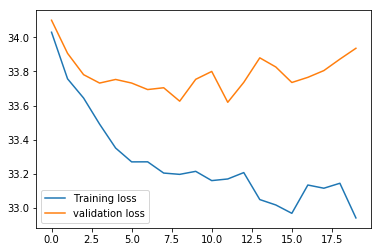

In [28]:
trained_linear_model = train_linear_model(
    learning_rate=0.001,
    steps=5e3,
    batch_size=50000,
    feature_columns=categorical_column,
    training_file=training_file,
    validation_file=validation_file)

Training model...
validation loss 34.28686
validation loss 34.076733
validation loss 33.91059
validation loss 33.92956
validation loss 33.831932
validation loss 33.848232
validation loss 33.69704
validation loss 33.76089
validation loss 33.705578
validation loss 33.75974
validation loss 33.706097
validation loss 33.749043
validation loss 33.602154
validation loss 33.77101
validation loss 33.741074
validation loss 33.66112
validation loss 33.629204
validation loss 33.73323
validation loss 33.80511
validation loss 33.661022
validation set metrics:
accuracy 0.57968
accuracy_baseline 0.55752
auc 0.593923
auc_precision_recall 0.6357724
average_loss 0.67322046
label/mean 0.55752
loss 33.661022
precision 0.5976763
prediction/mean 0.5509033
recall 0.7529057
global_step 5000
---


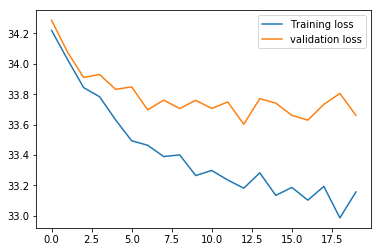

In [38]:
trained_linear_model = train_linear_model(
    learning_rate=0.0005,
    steps=5e3,
    batch_size=50000,
    feature_columns=categorical_column,
    training_file=training_file,
    validation_file=validation_file)

Training model...
validation loss 3243.3586
validation loss 3225.714
validation loss 3220.8455
validation loss 3219.426
validation loss 3218.9395
validation loss 3218.9119
validation loss 3218.8987
validation loss 3218.9563
validation loss 3218.937
validation loss 3218.979
validation loss 3219.064
validation loss 3219.0283
validation loss 3218.9255
validation loss 3218.8962
validation loss 3218.953
validation loss 3218.915
validation loss 3218.8113
validation loss 3218.9722
validation loss 3218.921
validation loss 3218.945
validation set metrics:
accuracy 0.5863327
accuracy_baseline 0.5524256
auc 0.602902
auc_precision_recall 0.63997936
average_loss 0.67149657
label/mean 0.5524256
loss 3218.945
precision 0.60126024
prediction/mean 0.5470391
recall 0.745725
global_step 5000
---


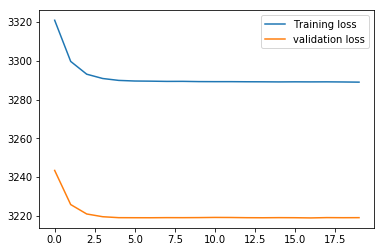

In [72]:
trained_linear_model = train_linear_model(
    learning_rate=0.0005,
    steps=5e3,
    batch_size=5000,
    feature_columns=categorical_column,
    training_file=training_file,
    validation_file=validation_file,
    compression_type="GZIP")

Training model...
validation loss 3290.868
validation loss 3274.1477
validation loss 3262.7312
validation loss 3254.0435
validation loss 3246.863
validation loss 3241.395
validation loss 3237.406
validation loss 3233.8887
validation loss 3231.262
validation loss 3229.705
validation loss 3228.1777
validation loss 3226.164
validation loss 3225.745
validation loss 3224.958
validation loss 3223.96
validation loss 3224.2324
validation loss 3223.593
validation loss 3223.4565
validation loss 3223.0923
validation loss 3222.7559
validation set metrics:
accuracy 0.5859396
accuracy_baseline 0.55225146
auc 0.60252357
auc_precision_recall 0.6390419
average_loss 0.6715866
label/mean 0.55225146
loss 3222.7559
precision 0.59855545
prediction/mean 0.5471199
recall 0.75986564
global_step 1000
---


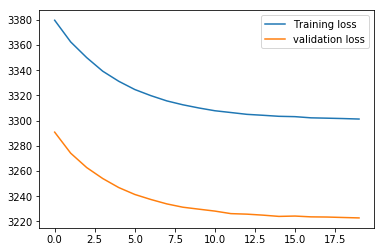

In [73]:
trained_linear_model = train_linear_model(
    learning_rate=0.0005,
    steps=1e3,
    batch_size=5000,
    feature_columns=categorical_column,
    training_file=training_file,
    validation_file=validation_file,
    compression_type="GZIP")

### Evaluate linear model on test set 
Don't do this until you're done tuning hyperparams!!

In [17]:
test_file = os.path.join('dota2_test_data', 'dota2_test_data.tfrecords')
test_input_fn =lambda: _input_fn([test_file])
evaluation_metrics = trained_linear_model.evaluate(
            input_fn=test_input_fn,
            steps=100)
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])

accuracy 0.5852
accuracy_baseline 0.5486
auc 0.6071559
auc_precision_recall 0.6377059
average_loss 0.67106634
label/mean 0.5486
loss 33.553318
precision 0.59609306
prediction/mean 0.5435795
recall 0.75647104
global_step 1000000


## Define and train a DNN model

### Define feature column constructor functions

In [74]:
def construct_indicator_columns(feature_columns):
    """Construct indicator columns for all features
            from categorical columns
        Args: 
            feature_columns: Set of 'tf.feature_column.categorical_column'
                to convert to indicator columns
        returns:
            a list of indicator columns
    """
    indicator_columns = []
    for column in list(feature_columns):
        indicator_columns.append(tf.feature_column.indicator_column(column))
        
    return indicator_columns
        

In [75]:
def construct_embedding_columns(feature_columns, dimension):
    """Construct embedding columns for all features
            from categorical columns
        Args:
            feature_columns: `Set` of 'tf.feature_column.categorical_column'
                to convert to embedding columns
            dimension: `int` that shows the 
        returns:
            a list of embedding columns
    """
            
    embedding_columns = []
    for column in list(feature_columns):
        embedding_columns.append(tf.feature_column.embedding_column(column,dimension=dimension))
        
    return embedding_columns

### Define model training function

In [94]:
def train_dnn_model(
    my_optimizer,
    hidden_units,
    steps,
    batch_size,
    feature_columns,
    training_file,
    validation_file,
    compression_type):
    """Trains a deep neural network regression model.
  
    In addition to training, this function also prints training progress information,
    as well as a plot of the training and validation loss over time.
      
    Args:
        learning_rate: A `float`, the learning rate.
        hidden_units: A `list` of `ints` specifying the number of layers and number 
            of nodes per layer.
        steps: A non-zero `int`, the total number of training steps. A training step
          consists of a forward and backward pass using a single batch.
        feature_columns: A `set` specifying the input feature columns to use.
        training_examples: A `DataFrame` containing one or more columns from
          `dota2_df` to use as input features for training.
        training_targets: A `DataFrame` containing exactly one column from
          `dota2_df` to use as target for training.
      
    Returns:
        A `DNNClassifer` object trained on the training data.
    """

    periods = 20
    steps_per_period = steps / periods

    # Create a dnn regressor object.
    dnn_classifier = tf.estimator.DNNClassifier(
      feature_columns=feature_columns,
      hidden_units=hidden_units,
      optimizer=my_optimizer
        )
  
    training_input_fn =lambda: _input_fn([training_file],batch_size=batch_size,
                                         compression_type=compression_type)
    validation_input_fn =lambda: _input_fn([validation_file],batch_size=batch_size,
                                    compression_type=compression_type)

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    
    
    training_loss = []
    validation_loss = []
    training_acc = []
    validation_acc = []
    for i in range(periods):
        # Train the model, starting from the prior state.
        dnn_classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period)
        
        # Take a break and compute predictions.
        evaluation_metrics = dnn_classifier.evaluate(
            input_fn=training_input_fn,
            steps=steps_per_period)
        training_loss.append(evaluation_metrics['loss'])
        training_acc.append(evaluation_metrics['accuracy'])
        
        evaluation_metrics = dnn_classifier.evaluate(
            input_fn=validation_input_fn,
            steps=steps_per_period)    
        validation_loss.append(evaluation_metrics['loss'])
        validation_acc.append(evaluation_metrics['accuracy'])
        print('validation loss', evaluation_metrics['loss'])

    print("validation set metrics:")
    for m in evaluation_metrics:
        print(m, evaluation_metrics[m])
    print("---")
    
    plt.plot(training_loss,label='Training loss')
    plt.plot(validation_loss,label='validation loss')
    plt.legend()
    plt.show()
    
    plt.plot(training_acc,label='Training accuracy')
    plt.plot(validation_acc,label='validation accuracy')
    plt.legend()
    plt.show()
    return dnn_classifier


### Specify path to tfrecord files and construct feature colums

In [92]:
training_file = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_training_data',
                             'radiant_windota2_training_data.tfrecords')
validation_file = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_validation_data',
                             'radiant_windota2_validation_data.tfrecords')

categorical_feature_columns = construct_hero_categorical_columns(['radiant_heroes','dire_heroes'],
                                                       hero_vocab)
indicator_feature_columns = construct_indicator_columns(categorical_feature_columns)

embed_dim = 4
embedding_feature_columns = construct_embedding_columns(categorical_feature_columns,dimension=embed_dim)

### Train model

Training model...
validation loss 3344.4912
validation loss 3331.1
validation loss 3324.325
validation loss 3320.6443
validation loss 3318.0244
validation loss 3314.1204
validation loss 3308.913
validation loss 3302.7795
validation loss 3294.4912
validation loss 3287.7593
validation loss 3280.5073
validation loss 3274.7808
validation loss 3268.6753
validation loss 3264.3958
validation loss 3261.0999
validation loss 3258.7358
validation loss 3258.418
validation loss 3256.0298
validation loss 3254.1794
validation loss 3252.583
validation set metrics:
accuracy 0.58357704
accuracy_baseline 0.5513217
auc 0.5995889
auc_precision_recall 0.63236165
average_loss 0.6730968
label/mean 0.5513217
loss 3252.583
precision 0.60126346
prediction/mean 0.54882056
recall 0.7264151
global_step 300
---


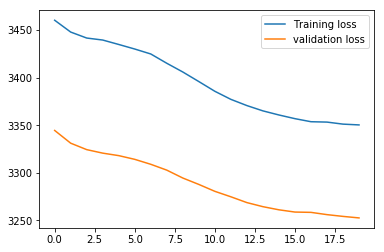

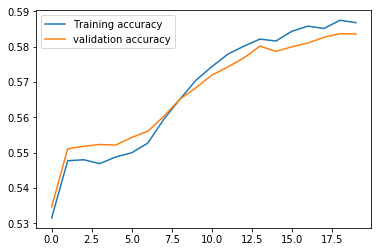

In [96]:
my_optimizer = tf.contrib.opt.AdamWOptimizer(weight_decay=0.0004, learning_rate=0.0025)
#my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

dnn_hidden_units = [10,10]
dnn_steps = 3e2
dnn_batch_size = 5000
trained_dnn_model = train_dnn_model(
    my_optimizer = my_optimizer,
    hidden_units = dnn_hidden_units,
    steps = dnn_steps,
    batch_size = dnn_batch_size,
    feature_columns=embedding_feature_columns,
    training_file=training_file,
    validation_file=validation_file,
    compression_type="GZIP")

Training model...
validation loss 3290.433
validation loss 3271.1013
validation loss 3249.6519
validation loss 3236.4456
validation loss 3230.5925
validation loss 3227.2646
validation loss 3225.775
validation loss 3225.2378
validation loss 3225.4004
validation loss 3224.992
validation loss 3225.3718
validation loss 3225.0225
validation loss 3225.103
validation loss 3225.358
validation loss 3225.29
validation loss 3225.2207
validation loss 3225.4956
validation loss 3225.5889
validation loss 3225.3416
validation loss 3226.196
validation set metrics:
accuracy 0.5841141
accuracy_baseline 0.5520597
auc 0.601388
auc_precision_recall 0.63740426
average_loss 0.67230344
label/mean 0.5520597
loss 3226.196
precision 0.6035378
prediction/mean 0.54368985
recall 0.71892434
global_step 1000
---


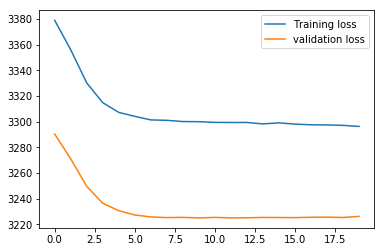

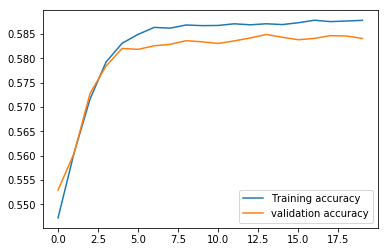

In [98]:
my_optimizer = tf.contrib.opt.AdamWOptimizer(weight_decay=0.0004, learning_rate=0.0025)
#my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

dnn_hidden_units = [10,10]
dnn_steps = 1e3
dnn_batch_size = 5000
trained_dnn_model = train_dnn_model(
    my_optimizer = my_optimizer,
    hidden_units = dnn_hidden_units,
    steps = dnn_steps,
    batch_size = dnn_batch_size,
    feature_columns=embedding_feature_columns,
    training_file=training_file,
    validation_file=validation_file,
    compression_type="GZIP")

Training model...
validation loss 3327.8733
validation loss 3322.6897
validation loss 3320.4304
validation loss 3319.4302
validation loss 3316.223
validation loss 3313.49
validation loss 3309.0159
validation loss 3305.6006
validation loss 3300.444
validation loss 3293.3074
validation loss 3288.1536
validation loss 3280.7102
validation loss 3274.8584
validation loss 3270.6562
validation loss 3266.0298
validation loss 3263.8743
validation loss 3260.1707
validation loss 3259.2888
validation loss 3257.0134
validation loss 3256.05
validation set metrics:
accuracy 0.5813145
accuracy_baseline 0.55191493
auc 0.5964869
auc_precision_recall 0.6326566
average_loss 0.67381424
label/mean 0.55191493
loss 3256.05
precision 0.6018005
prediction/mean 0.54616857
recall 0.7135108
global_step 300
---


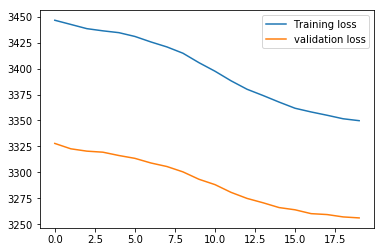

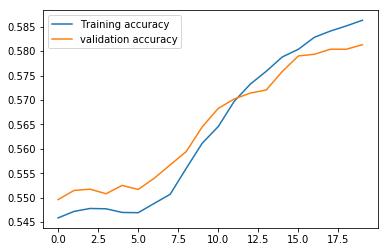

In [97]:
my_optimizer = tf.contrib.opt.AdamWOptimizer(weight_decay=0.0002, learning_rate=0.0025)
#my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

dnn_hidden_units = [10,10]
dnn_steps = 3e2
dnn_batch_size = 5000
trained_dnn_model = train_dnn_model(
    my_optimizer = my_optimizer,
    hidden_units = dnn_hidden_units,
    steps = dnn_steps,
    batch_size = dnn_batch_size,
    feature_columns=embedding_feature_columns,
    training_file=training_file,
    validation_file=validation_file,
    compression_type="GZIP")

Training model...
validation loss 3296.8928
validation loss 3281.278
validation loss 3254.5852
validation loss 3238.106
validation loss 3229.5234
validation loss 3227.1804
validation loss 3225.6035
validation loss 3225.4941
validation loss 3224.6396
validation loss 3225.1606
validation loss 3225.0266
validation loss 3225.6394
validation loss 3225.2866
validation loss 3225.5767
validation loss 3225.3145
validation loss 3225.5132
validation loss 3226.1943
validation loss 3225.5085
validation loss 3225.7932
validation loss 3226.1326
validation set metrics:
accuracy 0.5845934
accuracy_baseline 0.551943
auc 0.60160893
auc_precision_recall 0.6373349
average_loss 0.6722902
label/mean 0.551943
loss 3226.1326
precision 0.60186946
prediction/mean 0.5446683
recall 0.73077303
global_step 1000
---


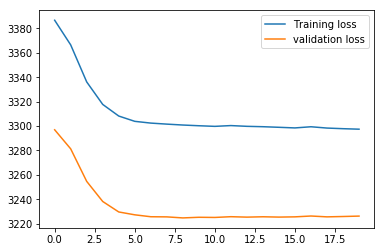

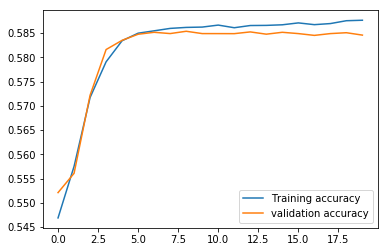

In [99]:
my_optimizer = tf.contrib.opt.AdamWOptimizer(weight_decay=0.0002, learning_rate=0.0025)
#my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

dnn_hidden_units = [10,10]
dnn_steps = 1e3
dnn_batch_size = 5000
trained_dnn_model = train_dnn_model(
    my_optimizer = my_optimizer,
    hidden_units = dnn_hidden_units,
    steps = dnn_steps,
    batch_size = dnn_batch_size,
    feature_columns=embedding_feature_columns,
    training_file=training_file,
    validation_file=validation_file,
    compression_type="GZIP")

Training model...
validation loss 3255.9958
validation loss 3231.1025
validation loss 3230.1382
validation loss 3230.206
validation loss 3233.0144
validation loss 3232.9453
validation loss 3230.375
validation loss 3233.991
validation loss 3231.357
validation loss 3237.4033
validation loss 3234.0903
validation loss 3236.1733
validation loss 3228.4004
validation loss 3228.6204
validation loss 3228.8748
validation loss 3229.221
validation loss 3228.1685
validation loss 3234.0022
validation loss 3227.7488
validation loss 3229.973
validation set metrics:
accuracy 0.58330554
accuracy_baseline 0.5522973
auc 0.60074043
auc_precision_recall 0.63784033
average_loss 0.6730905
label/mean 0.5522973
loss 3229.973
precision 0.59313244
prediction/mean 0.5661902
recall 0.78183764
global_step 500
---


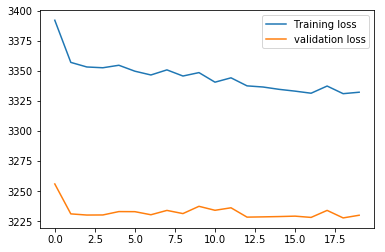

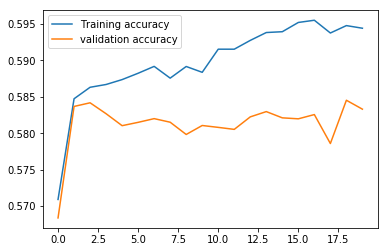

In [100]:
my_optimizer = tf.contrib.opt.AdamWOptimizer(weight_decay=0.002, learning_rate=0.025)
#my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

dnn_hidden_units = [10,10]
dnn_steps = 5e2
dnn_batch_size = 5000
trained_dnn_model = train_dnn_model(
    my_optimizer = my_optimizer,
    hidden_units = dnn_hidden_units,
    steps = dnn_steps,
    batch_size = dnn_batch_size,
    feature_columns=embedding_feature_columns,
    training_file=training_file,
    validation_file=validation_file,
    compression_type="GZIP")

Training model...
validation loss 3441.1733
validation loss 3438.388
validation loss 3430.6353
validation loss 3419.2715
validation loss 3409.6633
validation loss 3397.7124
validation loss 3393.3555
validation loss 3388.3828
validation loss 3382.8027
validation loss 3385.2788
validation loss 3377.53
validation loss 3382.464
validation loss 3379.9302
validation loss 3385.9238
validation loss 3386.1035
validation loss 3393.1646
validation loss 3393.2915
validation loss 3406.7466
validation loss 3396.5571
validation loss 3396.8003
validation set metrics:
accuracy 0.57264
accuracy_baseline 0.55304
auc 0.5840738
auc_precision_recall 0.6221058
average_loss 0.6793601
label/mean 0.55304
loss 3396.8003
precision 0.5969155
prediction/mean 0.5489535
recall 0.6998409
global_step 100
---


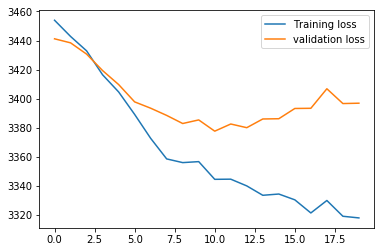

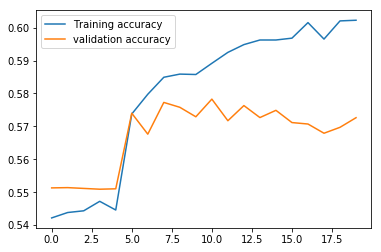

In [102]:
my_optimizer = tf.contrib.opt.AdamWOptimizer(weight_decay=0.002, learning_rate=0.025)
#my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

dnn_hidden_units = [10,10]
dnn_steps = 1e2
dnn_batch_size = 5000
trained_dnn_model = train_dnn_model(
    my_optimizer = my_optimizer,
    hidden_units = dnn_hidden_units,
    steps = dnn_steps,
    batch_size = dnn_batch_size,
    feature_columns=embedding_feature_columns,
    training_file=training_file,
    validation_file=validation_file,
    compression_type="GZIP")

### Validate model
only do this if you're done training!!

In [10]:
validation_file = os.path.join('dota2_validation_data', 'dota2_validation_data.tfrecords')
validation_input_fn =lambda: _input_fn([validation_file])
evaluation_metrics = trained_dnn_model.evaluate(
            input_fn=validation_input_fn,
            steps=3e4)
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])

accuracy 0.5890347
accuracy_baseline 0.543492
auc 0.6158235
auc_precision_recall 0.64411813
average_loss 0.6686505
label/mean 0.543492
loss 33.432526
precision 0.59568346
prediction/mean 0.5534632
recall 0.75902987
global_step 30000


### Investigate embeding layer

In [79]:
hero_list = interface('IEconDOTA2_570').GetHeroes(itemizedonly = True)['result']['heroes']

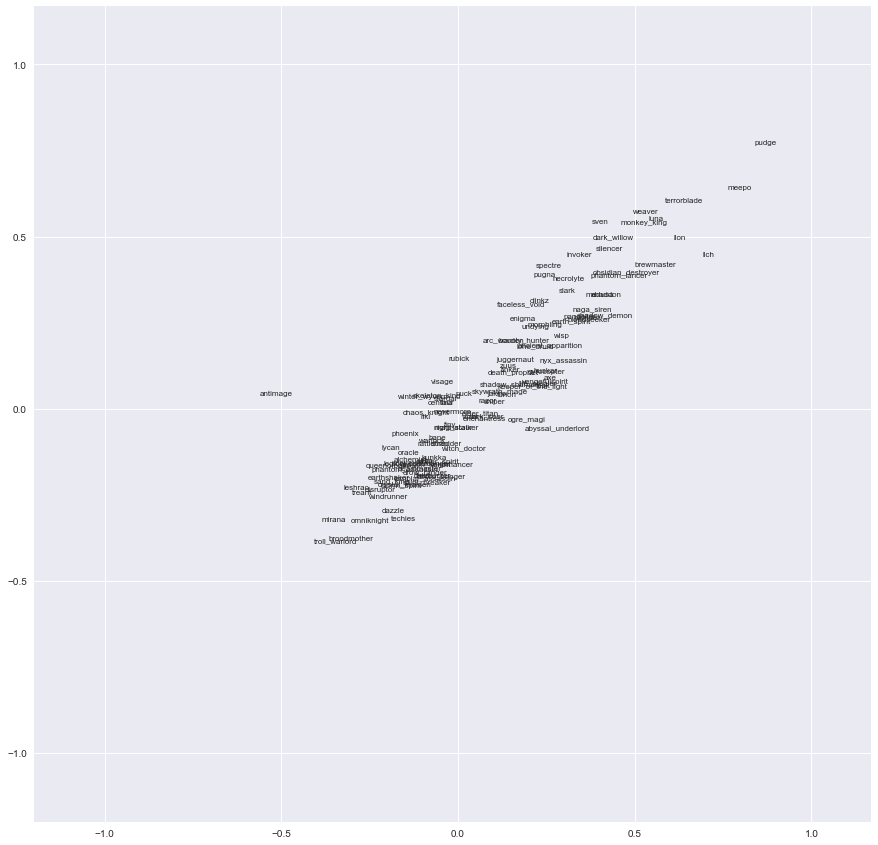

In [85]:
vocab = list(range(105))+list(range(106,114))+list(range(119,121))
dire_embedding_matrix = trained_dnn_model.get_variable_value(
    'dnn/input_from_feature_columns/input_layer/dire_heroes_embedding/embedding_weights')

radiant_embedding_matrix = trained_dnn_model.get_variable_value(
    'dnn/input_from_feature_columns/input_layer/radiant_heroes_embedding/embedding_weights')

for hero_index in range(len(vocab)):
    # Create a one-hot encoding for our term. It has 0s everywhere, except for
    # a single 1 in the coordinate that corresponds to that term.
    dire_vector = np.zeros(len(vocab))
    dire_vector[hero_index] = 1
    radiant_vector = np.zeros(len(vocab))
    radiant_vector[hero_index] = 1
    # We'll now project that one-hot vector into the embedding space.
    dire_embedding_xy = np.matmul(dire_vector, dire_embedding_matrix)
    radiant_embedding_xy = np.matmul(dire_vector,dire_embedding_matrix)
    #plt.text(dire_embedding_xy[0],
    #       dire_embedding_xy[1],
    #       hero_list[hero_index]['name'][14:],fontsize=8)
    plt.text(radiant_embedding_xy[0],
           radiant_embedding_xy[3],
           hero_list[hero_index]['name'][14:],fontsize=8,)

# Do a little setup to make sure the plot displays nicely.
plt.rcParams["figure.figsize"] = (15, 15)
plt.xlim(1.2 * dire_embedding_matrix.min(), 1.2 * dire_embedding_matrix.max())
plt.ylim(1.2 * dire_embedding_matrix.min(), 1.2 * dire_embedding_matrix.max())
plt.show() 

### Save a trained model for later exploration, or for on-demand prediction of test cases

In [103]:
def serving_input_receiver_fn():
    """An input receiver that expects a serialized tf.Example."""
    feature_spec = {
        "radiant_heroes": tf.FixedLenFeature([], dtype=tf.string), #array of five 8 bit ints for heroes
        "dire_heroes": tf.FixedLenFeature([], dtype=tf.string) #array of five 8-bit ints for heroes
                }
    serialized_tf_example = tf.placeholder(dtype=tf.string,
                                         shape=[1],
                                         name='input_example_tensor')
    receiver_tensors = {'examples': serialized_tf_example}
    parsed_features = tf.parse_example(serialized_tf_example, feature_spec)
    
    radiant_heroes = tf.decode_raw(parsed_features['radiant_heroes'], tf.int64)
    dire_heroes = tf.decode_raw(parsed_features['dire_heroes'], tf.int64)
    
    features = {'radiant_heroes':radiant_heroes, 'dire_heroes': dire_heroes}
    
    return tf.estimator.export.ServingInputReceiver(features, receiver_tensors)

In [104]:
export_dir = os.path.join('trained_models','dnn_models')
trained_dnn_model.export_savedmodel(
                                export_dir_base = export_dir,
                                serving_input_receiver_fn = serving_input_receiver_fn)

b'trained_models/dnn_models/1563329122'

In [105]:
export_dir = os.path.join('trained_models','linear_models')
trained_linear_model.export_savedmodel(
                                export_dir_base = export_dir,
                                serving_input_receiver_fn = serving_input_receiver_fn)

b'trained_models/linear_models/1563329152'

# Preprocessing, input functions, and linear training for DataFrame data format

## Preprocess functions for input without TFRecords format

In [46]:
#Split training and validation datasets with a given training fraction. 

#to begin with we have a sample of 7050 matches to validation the model with.
#This may not be enough games to accurately determine win probability but probably good enough for first validations

training_fraction = 0.7
head_num = int(training_fraction * len(dota2_df))
tail_num = len(dota2_df)-head_num

training_examples = preprocess_features(dota2_df.head(head_num))
training_targets = preprocess_targets(dota2_df.head(head_num))

validation_examples = preprocess_features(dota2_df.tail(tail_num))
validation_targets = preprocess_targets(dota2_df.tail(tail_num))

#print("Training features summary")
#training_examples.style
print("\nTraining targets summary")
display.display(training_targets.describe())

#print("\nvalidation feature summary")
#validation_examples.style
print("\nvalidation target summary")
display.display(validation_targets.describe())


Training targets summary


,radiant_win
count,6157.000000
mean,0.549943
std,0.497540
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000



validation target summary


,radiant_win
count,2640.000000
mean,0.549242
std,0.497664
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [3]:
def preprocess_features(dota2_df):
    """Take dota2_df and create a dataframe containing only the features for our model
            Args: 
                dota2_df: Dataframe containing dota2 training and test data
            returns: 
                processed_df: pandas DataFrame containing only feature columns
    """
    
    #Use arrays of heroes for each team as features rather than each hero
    #individually to help model fit?
    #This is an attempt to make the model more similar to the movie review
    #text analysis example in the Google ML Crash Course
    processed_df = pd.DataFrame()
    
    processed_df['radiant_heroes'] = list(np.array(dota2_df.loc[:,['radiant_heroes0',
                                                'radiant_heroes1','radiant_heroes2',
                                                'radiant_heroes3','radiant_heroes4']]))
    processed_df['dire_heroes'] = list(np.array(dota2_df.loc[:,['dire_heroes0',
                                    'dire_heroes1','dire_heroes2',
                                    'dire_heroes3','dire_heroes4']]))
    
    ##only features (to start with) are the heroes in the game
    #processed_df = dota2_df[['radiant_heroes0', 'radiant_heroes1',
    #                   'radiant_heroes2', 'radiant_heroes3', 'radiant_heroes4',
    #                    'dire_heroes0', 'dire_heroes1', 'dire_heroes2',
    #                    'dire_heroes3', 'dire_heroes4']]
    
    ##create two synthetic features that is the product of all heroes for each team
    #processed_df['radiant_hero_product'] = dota2_df['radiant_heroes0']*dota2_df['radiant_heroes1']*dota2_df['radiant_heroes2']dota2_df['radiant_heroes3']*dota2_df['radiant_heroes4']
    #processed_df['dire_hero_product'] = dota2_df['dire_heroes0']*dota2_df['dire_heroes1']*dota2_df['dire_heroes2']dota2_df['dire_heroes3']*dota2_df['dire_heroes4']
    
    return processed_df
    
def preprocess_targets(dota2_df):
    """Take dota2_df and create a dataframe containing only the targets for our model
            Args: 
                dota2_df: Dataframe containing dota2 training and test data
            returns: 
                target_df: pandas DataFrame containing only the target column
    """
    target_df = pd.DataFrame()
    target_df['radiant_win'] = dota2_df['radiant_win']
    
    return target_df

## Build Functions for doing linear classifier modelling without TFRecords

In [77]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a logistic regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = tf.data.Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
        ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

### DNN model training 

In [86]:
def train_dnn_model(
    learning_rate,
    regularization,
    hidden_units,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets):
    """Trains a deep neural network regression model.
  
    In addition to training, this function also prints training progress information,
    as well as a plot of the training and validation loss over time.
      
    Args:
        learning_rate: A `float`, the learning rate.
        l1_regularization: A `float`, the L1 regularization rate. This regularizatin 
          penalizes non-zero weights in the model to prevent overfitting as well as
          save memory.
        l2_regularization: A `float`, the L2 regularization rate. This regularization
          penalizes large weights in the model to prevent overfitting.
        hidden_units: A list of `ints`, the number of nodes in each layer for the DNN
          model.
        steps: A non-zero `int`, the total number of training steps. A training step
          consists of a forward and backward pass using a single batch.
        feature_columns: A `set` specifying the input feature columns to use.
        training_examples: A `DataFrame` containing one or more columns from
          `dota2_df` to use as input features for training.
        training_targets: A `DataFrame` containing exactly one column from
          `dota2_df` to use as target for training.
      
    Returns:
        A `DNNClassifer` object trained on the training data.
    """

    periods = 10
    steps_per_period = steps / periods

    # Create a linear regressor object.
    my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    dnn_classifier = tf.estimator.DNNClassifier(
      feature_columns=feature_columns,
      hidden_units=hidden_units,
      optimizer=my_optimizer
      )
  
    training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["radiant_win"], 
                                          batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["radiant_win"], 
                                                  num_epochs=1, 
                                                  shuffle=False)

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        dnn_classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period
            )
        # Take a break and compute predictions.
        training_predictions = dnn_classifier.predict(input_fn=predict_training_input_fn)
    
    print("Model training finished.")


    return dnn_classifier

In [ ]:
trained_linear_model = train_dnn_model(
    learning_rate=0.07,
    regularization=0.01
    steps=1000,
    batch_size=100,
    feature_columns=construct_hero_categorical_columns(training_examples),
    training_examples=training_examples,
    training_targets=training_targets)